##### This analysis is done in python primarily using the pandas library, and jupyter notebook as an interactive interpreter.

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from scipy import stats
pd.options.display.max_rows = 30

df = pd.read_csv("/Users/Hegstrom/Desktop/HCT390_assignment_ACO data file_downloaded.csv", thousands=',', na_values=['-'])
# Getting everything loaded up, and setting up the dataframe.

# All of these are from appendix A in the quality benchmark guideline PDF.
patient_caregiver_columns = ['ACO1','ACO2','ACO3','ACO4','ACO5',
                             'ACO6','ACO7','ACO34']

care_coordination_patient_safety_columns = ['ACO8', 'ACO35', 'ACO36',
                                            'ACO37', 'ACO38', 'ACO43',
                                           'ACO11', 'ACO12', 'ACO13', 'ACO44']

preventative_health_columns = ['ACO14', 'ACO15', 'ACO16', 'ACO17',
                              'ACO18', 'ACO19', 'ACO20', 'ACO42']

at_risk_depression_column = ['ACO40']

at_risk_dm_columns = ['ACO27', 'ACO41', 'DM_Comp']

at_risk_htn_column = ['ACO28']

at_risk_ischemic_vasc_column = ['ACO30']

at_risk_columns = at_risk_depression_column + at_risk_dm_columns + at_risk_htn_column + at_risk_ischemic_vasc_column

# Question #6

#### What kinds of recommendations would you make for poorly performing ACOs? Thinking back on class discussion about platforms, do you see any connections to improving performance?

From the experiences we get to have as medical students, we can see directly what quality patient care looks like at the individual level. Zooming out to evaluate a whole population is kind of challenging. One can imagine that we have a skewed view, since our patients showed up the clinic, whereas those that are higher risk may never go until they arrive by ambulance. 

One question I wondered is if ACOs that are highly ranked in quality in one category are also highly ranked in other categories? Let's find out.

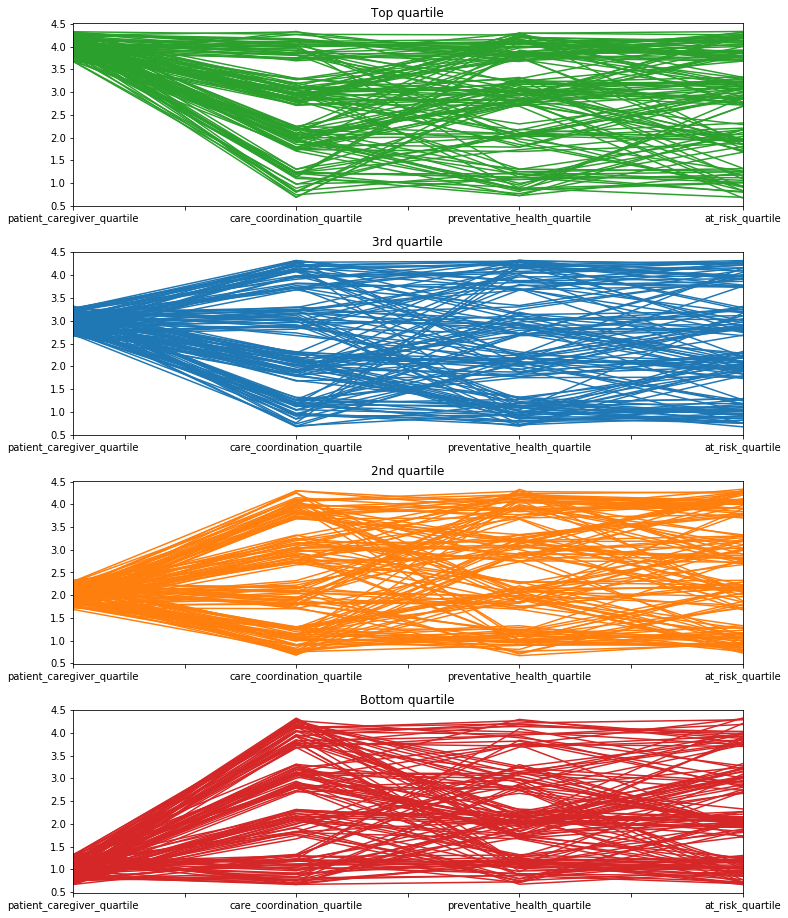

In [2]:
testing_ranking = df.copy()
# First, I'm inversing the scale, so everything is + = +.
testing_ranking['ACO8'] = 100 - testing_ranking['ACO8']
testing_ranking['ACO27'] = 100 - testing_ranking['ACO27']
testing_ranking['ACO35'] = 100 - testing_ranking['ACO35']
testing_ranking['ACO36'] = 100 - testing_ranking['ACO36']
testing_ranking['ACO37'] = 100 - testing_ranking['ACO37']
testing_ranking['ACO38'] = 100 - testing_ranking['ACO38']
testing_ranking['ACO43'] = 100 - testing_ranking['ACO43']


# This aggregates the scores for the categories for each organization.
testing_ranking['patient_caregiver_score'] = testing_ranking[patient_caregiver_columns].sum(axis=1)
testing_ranking['care_coordination_score'] = testing_ranking[care_coordination_patient_safety_columns].sum(axis=1)
testing_ranking['preventative_health_score'] = testing_ranking[preventative_health_columns].sum(axis=1)
testing_ranking['at_risk_score'] = testing_ranking[at_risk_depression_column + at_risk_dm_columns + at_risk_htn_column + at_risk_ischemic_vasc_column].sum(axis=1)

# This assigns their quartile rank in each quality category.
testing_ranking['patient_caregiver_quartile'] = pd.qcut(testing_ranking['patient_caregiver_score'], 4, labels=False) + 1
testing_ranking['care_coordination_quartile'] = pd.qcut(testing_ranking['care_coordination_score'], 4, labels=False) + 1
testing_ranking['preventative_health_quartile'] = pd.qcut(testing_ranking['preventative_health_score'], 4, labels=False) + 1
testing_ranking['at_risk_quartile'] = pd.qcut(testing_ranking['at_risk_score'], 4, labels=False) + 1

# And now we're slicing the data to only the categories needed.
testing_ranking = testing_ranking[
    ['patient_caregiver_quartile', 'care_coordination_quartile', 'preventative_health_quartile', 'at_risk_quartile']
]

# This adds a label for which quartile the organization ranks for the Patient / Caregiver category.
testing_ranking['label'] = testing_ranking['patient_caregiver_quartile'].astype(str)
quartile_dict = {
    "1": "Bottom quartile",
    "2": "2nd quartile",
    "3": '3rd quartile',
    "4": 'Top quartile'
}
testing_ranking['label'] = testing_ranking['label'].map(quartile_dict)



# Adding random jitter to the quartiles for the graphs. Otherwise all of the lines are on top of each other.
testing_ranking = testing_ranking.set_index('label')
testing_ranking = testing_ranking + ((np.random.random(testing_ranking.values.shape) - 0.5) / 1.5) # jitter adjustment here.
testing_ranking = testing_ranking.reset_index()

colors = ['#2CA02CFF', '#1F77B4FF', '#FF7F0EFF','#D62728FF'] # for the charts.
fig, axes = plt.subplots(4, 1, figsize=(12, 16))
plt.subplots_adjust(wspace=0.25, hspace=0.25)
for i, quartile in enumerate(['Top quartile', '3rd quartile', '2nd quartile', 'Bottom quartile']):
    testing_ranking[testing_ranking['label'] == quartile].set_index('label').T.plot(kind='line',
                                                                                    legend=False,
                                                                                    rot=0,
                                                                                    c=colors[i],
                                                                                    ax=axes[i]
                                                                                   )
    axes[i].set_title(quartile)

The chart above looks at how organizations quartile rank changes across the categories. The 4 charts are broken apart based on what quartile they rank in the Patient / Caregiver category. From there, each line represents an individual organization. Some will go from the top to the bottom, some straight across the time, and others bouce around.

So, from the chart above, there doesn't seem to be a whole lot of consistency. An organization that sucks at the patient / caregiver attribute, may actually be awesome at the care coordination attribute.

There does appear to be some correlations within these graphs, but it does show the defining poor performing can be a little more involved.

A Sankey diagram might provide some more insight. Let's create one.

Unfortunately, python does not have a great sankey chart. It's been lacking since at-least 2014... And it still isn't solved. There are multiple javascript libraries that have solved it, however.

In [3]:
# Let's create the data for it.
testing_ranking = testing_ranking.drop('label', axis=1)
testing_ranking = np.round(testing_ranking, 0)
for col in testing_ranking.columns:
    testing_ranking[col] = testing_ranking[col].astype(str) + " {}".format(col)

node_edge_list = []

# This is an anti-pattern. iterating rows in pandas is almost never the right answer, and is inefficient
# But, trying build a list of dicts using vectorized methods is a pain, and our sample size is small.
# so I'm break the rules.
for index, row in testing_ranking[['patient_caregiver_quartile','care_coordination_quartile']].iterrows():
    data_dict = {
        'source': row['patient_caregiver_quartile'],
        'target': row['care_coordination_quartile'],
        'value': 1
    }
    node_edge_list += [data_dict]
    
for index, row in testing_ranking[['care_coordination_quartile','preventative_health_quartile']].iterrows():
    data_dict = {
        'source': row['care_coordination_quartile'],
        'target': row['preventative_health_quartile'],
        'value': 1
    }
    node_edge_list += [data_dict]
    
for index, row in testing_ranking[['preventative_health_quartile','at_risk_quartile']].iterrows():
    data_dict = {
        'source': row['preventative_health_quartile'],
        'target': row['at_risk_quartile'],
        'value': 1
    }
    node_edge_list += [data_dict]
    
    
#Spitting out the data in a format Google's charting tool wants it.
node_edge_df = pd.DataFrame(node_edge_list)
node_edge_df.groupby(['source', 'target']).sum().reset_index().values.tolist()

[['1.0 care_coordination_quartile', '1.0 preventative_health_quartile', 67],
 ['1.0 care_coordination_quartile', '2.0 preventative_health_quartile', 35],
 ['1.0 care_coordination_quartile', '3.0 preventative_health_quartile', 25],
 ['1.0 care_coordination_quartile', '4.0 preventative_health_quartile', 10],
 ['1.0 patient_caregiver_quartile', '1.0 care_coordination_quartile', 40],
 ['1.0 patient_caregiver_quartile', '2.0 care_coordination_quartile', 27],
 ['1.0 patient_caregiver_quartile', '3.0 care_coordination_quartile', 33],
 ['1.0 patient_caregiver_quartile', '4.0 care_coordination_quartile', 37],
 ['1.0 preventative_health_quartile', '1.0 at_risk_quartile', 93],
 ['1.0 preventative_health_quartile', '2.0 at_risk_quartile', 36],
 ['1.0 preventative_health_quartile', '3.0 at_risk_quartile', 8],
 ['2.0 care_coordination_quartile', '1.0 preventative_health_quartile', 43],
 ['2.0 care_coordination_quartile', '2.0 preventative_health_quartile', 40],
 ['2.0 care_coordination_quartile', '3

In [4]:
from IPython.display import IFrame
IFrame(src="//jsfiddle.net/aez9hvmk/3/embedded/result/", width=910, height=400)

#### Github won't display an iFrame. There's some web vulnerability considerations for why they don't allow it. Please use the link below to view the chart. Pro tip: drag the borders of the result area to make it bigger so you can actually see the chart :)
    
https://jsfiddle.net/aez9hvmk/3/
    
This is created using Google's charting library. There's no way to control the order in which the nodes appear (which is driving me crazy -> goes from 2nd to 1st to 3rd to 4th quartiles..).

### The higher the quartile the better! 4.0 quartile = top performance, despite being on the bottom

When looking at the patient / caregiver there's relatively little correlation to the care / coordination metrics.

The care / coordination metrics have a little bit more correlation with preventative health. But, preventative health and at-risk metrics have a strong amount of correlation. Which is interesting.

One could shuffle the order in which the categories to see other correlations. Creating a graph trying to show them all kinda ends up creating a hairball chart that isn't helpful.